## Sample notebook on loading asset prices + calculating PnL
based on a simple equal-weighted, monthly rebalanced strategy

In [ ]:
import pandas as pd
from utils.data.source import YahooFinanceDB
from utils.trading.backtest import Portfolio, TCost, Backtest, Performance

In [2]:
START = pd.Timestamp(1999, 11, 30)
END = pd.Timestamp(2025, 4, 20)

In [3]:
tickers = ["^SPX",'^FTSE', "^GDAXI", "^HSI", "^N225"]

### Loading data from the internally onboarded YahooFinance data

In [4]:
yf_db = YahooFinanceDB()
prices_ts = yf_db.load_timeseries(ids=tuple(tickers),
                                  fld='Close',
                                  start=START,
                                  end=END)

In [5]:
prices_ts.ffill(inplace=True)

<AxesSubplot:title={'center':'Historical Prices'}, xlabel='DATE'>

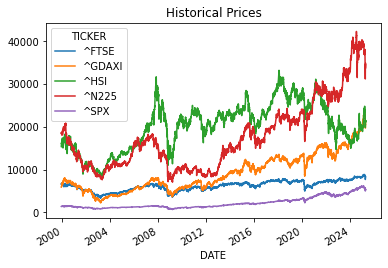

In [25]:
prices_ts.plot(title='Historical Prices')

In [7]:
yf_db.load_info(tickers).loc['longName']

TICKER
^FTSE                            FTSE 100
^GDAXI    DAX                           P
^HSI                      HANG SENG INDEX
^N225                          Nikkei 225
^SPX                        S&P 500 INDEX
Name: longName, dtype: object

### A monthly rebalanced portfolio

In [ ]:
_date_range = pd.date_range(START, END, freq='BM')

In [8]:
_date_range = pd.date_range(START, END, freq='BM')
bm_index_prices_ts = prices_ts.ffill(limit=1).reindex(_date_range, method='ffill')
# equal-weighted portfolio
h_df = bm_index_prices_ts/bm_index_prices_ts * (1/len(tickers))

### Rebalanced weights

In [14]:
h_df.tail(5)

TICKER,^FTSE,^GDAXI,^HSI,^N225,^SPX
2024-11-29,0.2,0.2,0.2,0.2,0.2
2024-12-31,0.2,0.2,0.2,0.2,0.2
2025-01-31,0.2,0.2,0.2,0.2,0.2
2025-02-28,0.2,0.2,0.2,0.2,0.2
2025-03-31,0.2,0.2,0.2,0.2,0.2


In [15]:
pf = Portfolio(h_df)

### Drifted weights immediately prior to rebalancing on each rebalance date

In [16]:
pf.drifted_wgts(prices_ts)

TICKER,^FTSE,^GDAXI,^HSI,^N225,^SPX
1999-11-30,0.200000,0.200000,0.200000,0.200000,0.200000
1999-12-01,0.200687,0.200491,0.199801,0.198545,0.200477
1999-12-02,0.200018,0.199704,0.201232,0.197851,0.201194
1999-12-03,0.199931,0.203034,0.201524,0.193627,0.201883
1999-12-06,0.197795,0.203073,0.204968,0.194399,0.199766
...,...,...,...,...,...
2025-04-14,0.200073,0.199592,0.195562,0.201413,0.203360
2025-04-15,0.201395,0.200941,0.194558,0.201600,0.201506
2025-04-16,0.203893,0.203329,0.192597,0.201386,0.198795
2025-04-17,0.202867,0.201305,0.194702,0.203071,0.198055


In [17]:
tcost = TCost(0.01) # a harsh T-cost of 100 bps

In [18]:
bkt = Backtest(pf, prices_ts, tcost)
perf = bkt.run()

In [19]:
pre_tc = perf.cumulative_agg_ts(post_tc=False)
post_tc = perf.cumulative_agg_ts(post_tc=True)

<AxesSubplot:title={'center':'Absolute Cumulative Return'}>

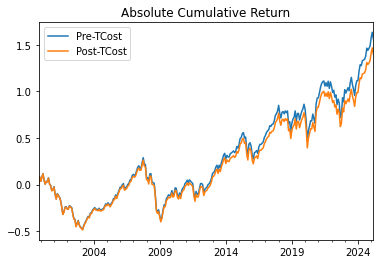

In [22]:
pd.concat([pre_tc.rename('Pre-TCost'), 
           post_tc.rename('Post-TCost')], axis=1).plot(title='Absolute Cumulative Return')

<AxesSubplot:title={'center':'Underwater plot'}>

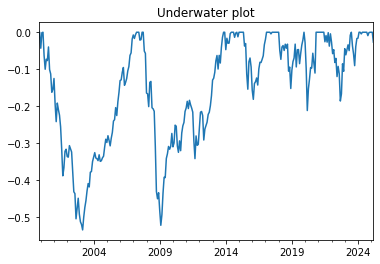

In [24]:
perf.underwater_ts().plot(title='Underwater plot')